# Introduction to Aquila

In the previous notebook, we have introduced the concept of Analog Hamiltonian Simulation (AHS) and how to run an AHS program on a Rydberg-based local simulator. In this notebook, we will illustrate how to run an AHS program on QuEra's Aquila, a Rydberg based QPU, via Amazon Braket. 


Some feedback on notebook 01:
Let's start with the device, similar to here: https://quip-amazon.com/CQlFApD7TGPU/Run-your-2nd-Analog-Hamiltonian-Simulation-workload
connect to it, get name, get capabilities, show how to understand those capabilities
When mentioning the constraints on atom array and time series, explicitly call out the corresponding device capability variables names (not only the numerical values).
Make all cells runable, and verify that they do run (except the "Result" section for now)

move device section up to the first part.


bring up the capability dict, they may change

## Quera's Aquila

In order to use Aquila device, let us first connect to it, and query its parameters with its unique Amazon Resource Number (ARN).

<div class="alert alert-block alert-info">
<b>Note </b> You need to pip install the <a href="https://github.com/aws/amazon-braket-sdk-python#installing-the-amazon-braket-python-sdk" class="alert-link">Braket SDK</a>. If you are new to Amazon Braket, make sure you have completed the necessary <a href="https://docs.aws.amazon.com/braket/latest/developerguide/braket-get-started.html" class="alert-link">Get Started steps</a>. If you are using a Braket hosted notebook instance, this SDK comes pre-installed with the notebooks.
</div>


In [21]:
from braket.aws import AwsDevice 
from pprint import pprint as pp

device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

capabilities = device.properties.paradigm

pp(capabilities.dict())

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.0001'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02'),
                                               'singleQubitFidelity': Decimal('0.95'),
                                               'twoQubitFidelity': Decimal('0.95')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125663700.0'),
                                    

In the following sections, we will go through these device capabilities and build an AHS program that comply with these constraints.

## Building an AHS program for Aquila

We have seen the basic components of an AHS program in the previous example, including the register, the driving and shifting fields. In order to run an AHS program on Aquila, however, these components have to meet certain requirements. Particularly, the first version of Aquila will not support shifting field. In this section, we will introduce other constraints via building up a valid program for Aquila step by step. 

### Register
In contrast to the local simulator which can only simulate a handful of atoms, Aquila can simulate systems with a few hundred atoms. The coordinates of the atoms, however, have to meet the following constraints. We can check the requirements as follows

In [15]:
lattice_constraints = capabilities.lattice
pp(lattice_constraints.dict())

{'area': {'height': Decimal('0.0001'), 'width': Decimal('0.000075')},
 'geometry': {'numberSitesMax': 256,
              'positionResolution': Decimal('1E-7'),
              'spacingRadialMin': Decimal('0.000004'),
              'spacingVerticalMin': Decimal('0.000004')}}


The detailed description of these sections can be inspected as follows

In [19]:
print(lattice_constraints.area.__doc__)
print(lattice_constraints.geometry.__doc__)


    The area of the FOV
    Attributes:
        width (Decimal): Largest allowed difference between x
            coordinates of any two sites (measured in meters)
        height (Decimal): Largest allowed difference between y
            coordinates of any two sites (measured in meters)
    

    Spacing or number of sites or rows
    Attributes:
        spacingRadialMin (Decimal): Minimum radial spacing between any
            two sites in the lattice (measured in meters)
        spacingVerticalMin (Decimal): Minimum spacing between any two
            rows in the lattice (measured in meters)
        positionResolution (Decimal): Resolution with which site positions
            can be specified (measured in meters)
        numberSitesMax (int): Maximum number of sites that can be placed
            in the lattice
    


As we can see, the requirements for the setup of the AHS program can be summarized as follows
1. The number of sites in the setup cannot be greater than `capabilities.lattice.geometry.numberSitesMax`
2. The atoms have to be separated by at least `capabilities.lattice.geometry.spacingRadialMin` meters
3. The rows in the setup have to be separated by at least `capabilities.lattice.geometry.spacingVerticalMin` meters
4. The resolution for the coordinates of the atoms cannot be greater than `capabilities.lattice.geometry.positionResolution` meters
5. The setup cannot be wider than `capabilities.lattice.area.width` meters
6. The setup cannot be taller than `capabilities.lattice.area.height` meters

Below, we demonstrate a valid setup that meets these requirements, which has 144 atoms grouped as 48 well separated equilateral triangles.

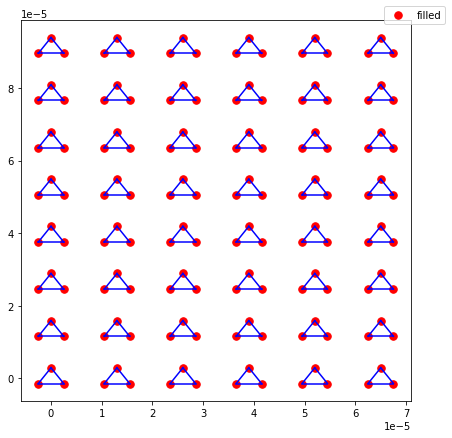

In [65]:
import numpy as np
from braket.ahs.atom_arrangement import AtomArrangement
from utils import show_register

separation = 5e-6
block_separation = 13e-6
k_max = 8
m_max = 6

register = AtomArrangement()
for k in range(k_max):
    for m in range(m_max):
        register.add((block_separation*m, block_separation*k + separation/np.sqrt(3)))
        register.add((block_separation*m-separation/2, block_separation*k - separation/(2*np.sqrt(3))))
        register.add((block_separation*m+separation/2, block_separation*k - separation/(2*np.sqrt(3))))        

show_register(register, show_atom_index=False, blockade_radius= 1.5 * separation)

### Driving field

Aquila can simulate the following Hamiltonian 

\begin{align}
H(t) = \sum_{k=1}^N H_{\text{drive}, k}(t) + \sum_{j=1}^N\sum_{k = j}^N H_{\text{vdW}, j, k}.
\end{align}
Here the second term is the interaction term which is fixed once the setup is defined, and the first term is the driving field,
\begin{align}
H_{\text{drive}, k}(t) = \frac{\Omega(t)}{2}\left(e^{i\phi(t)}\sigma_k + e^{-i\phi(t)}\sigma_k^\dagger\right) - \Delta_\text{global}(t)n_k,
\end{align}
which act on all the atoms in the setup. The specification of the driving field has to satisfy several conditions, which can be queried as follows

In [24]:
rydberg = capabilities.rydberg
pp(rydberg.dict())

{'c6Coefficient': Decimal('5.42E-24'),
 'rydbergGlobal': {'detuningRange': (Decimal('-125663700.0'),
                                     Decimal('125663700.0')),
                   'detuningResolution': Decimal('0.2'),
                   'detuningSlewRateMax': Decimal('2500000000000000.0'),
                   'phaseRange': (Decimal('-99.0'), Decimal('99.0')),
                   'phaseResolution': Decimal('5E-7'),
                   'rabiFrequencyRange': (Decimal('0.0'),
                                          Decimal('12566370.0')),
                   'rabiFrequencyResolution': Decimal('400.0'),
                   'rabiFrequencySlewRateMax': Decimal('250000000000000.0'),
                   'timeDeltaMin': Decimal('1E-8'),
                   'timeMax': Decimal('0.000004'),
                   'timeMin': Decimal('0.0'),
                   'timeResolution': Decimal('1E-9')}}


`c6Coefficient` is the constant for the interaction strength between two Rydberg atoms. The detailed description for the `rydbergGlobal` section can be inspected as follows

In [28]:
print(rydberg.rydbergGlobal.__doc__)


    Parameters determining the limitations on the driving field that drives the
        ground-to-Rydberg transition uniformly on all atoms
    Attributes:
        rabiFrequencyRange (Tuple[Decimal,Decimal]): Achievable Rabi frequency
            range for the global Rydberg drive waveform (measured in rad/s)
        rabiFrequencyResolution (Decimal): Resolution with which global Rabi
            frequency amplitude can be specified (measured in rad/s)
        rabiFrequencySlewRateMax (Decimal): Maximum slew rate for changing the
            global Rabi frequency (measured in (rad/s)/s)
        detuningRange(Tuple[Decimal,Decimal]): Achievable detuning range for
            the global Rydberg pulse (measured in rad/s)
        detuningResolution(Decimal): Resolution with which global detuning can
            be specified (measured in rad/s)
        detuningSlewRateMax (Decimal): Maximum slew rate for detuning (measured in (rad/s)/s)
        phaseRange(Tuple[Decimal,Decimal]): Achievabl

As we can see, the requirements for the driving field in the AHS program can be summarized as follows

1. The Rabi frequency $\Omega(t)$ have to be within the range `rydberg.rydbergGlobal.rabiFrequencyRange`, in the unit of rad/s
2. The resolution for the Rabi frequency cannot be greateer than `rydberg.rydbergGlobal.rabiFrequencyResolution` rad/s
3. The slew rate for the Rabi frequency cannot be greateer than `rydberg.rydbergGlobal.rabiFrequencySlewRateMax` (rad/s)/s

4. The phase $\phi(t)$ have to be within the range `rydberg.rydbergGlobal.phaseRange`, in the unit of rad
5. The resolution for the phase cannot be greateer than `rydberg.rydbergGlobal.phaseResolution` rad

6. The detuning $\Delta(t)$ have to be within the range `rydberg.rydbergGlobal.detuningRange`, in the unit of rad
7. The resolution for the detuning cannot be greateer than `rydberg.rydbergGlobal.detuningResolution` rad
8. The slew rate for the detuning cannot be greateer than `rydberg.rydbergGlobal.detuningSlewRateMax` rad/s

9. The duration of the driving field cannot be less than `rydberg.rydbergGlobal.timeMin` seconds
10. The duration of the driving field cannot be more than `rydberg.rydbergGlobal.timeMax` seconds
11. The time points have to be separated by at least `rydberg.rydbergGlobal.timeDeltaMin` seconds
12. The resolution for the time points cannot be greateer than `rydberg.rydbergGlobal.timeResolution` seconds

Besides, there are three additional requirements
1. The Rabi frequency $\Omega(t)$ has to start with 0 rad/s
2. The Rabi frequency $\Omega(t)$ has to end with 0 rad/s
3. The phase $\phi(t)$ has to start with 0 rad
4. All the fields in the driving field have to end at the same time point.
5. For each field in the driving field, the number of time points has to be the same as that of values

Below, we demonstrate a valid driving field for Aquila.

In [70]:
from braket.ahs.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

amplitude_value = 1.25e7   # rad / s
detuning_value = 2 *amplitude_value  # rad / s

time_max = np.pi/(4 * amplitude_value)  # s
time_ramp = 6e-8  # s

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [0, amplitude_value, amplitude_value, 0]
detuning_values = [detuning_value, detuning_value, detuning_value, detuning_value]
phase_values = [0, 16.89, -78.1, 34.8] 

amplitude = TimeSeries()
for t, v in zip(time_points, amplitude_values):
    amplitude.put(t, v)

detuning = TimeSeries()
for t, v in zip(time_points, detuning_values):
    detuning.put(t, v)

phase = TimeSeries()
for t, v in zip(time_points, phase_values):
    phase.put(t, v)

    
drive = DrivingField(
    amplitude=amplitude, 
    detuning=detuning, 
    phase=phase
)


We can inspect the driving field in the following way 

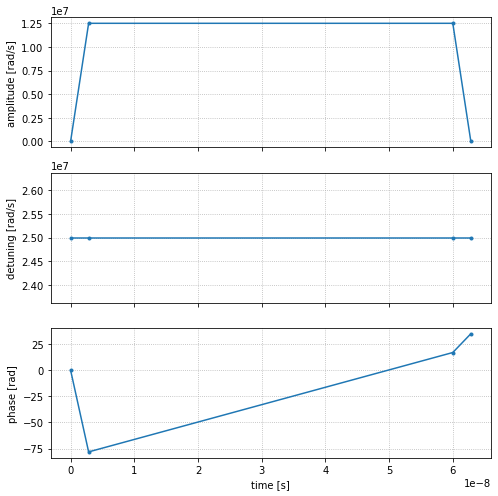

In [71]:
from utils import show_global_drive
show_global_drive(drive)

### AHS program

We can assemble the register and Hamiltonian to an AHS program 

In [74]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

### Task 

Before submitting the AHS program to Aquila, we can discretize the program to ensure that it complies with resolution-specific validation rules. 

Question: Are we discretizing the program by default?

In [75]:
discretized_ahs_program = ahs_program.discretize(device)

In [ ]:
The AHS program can be submitted to the device to create a quantum task on the Braket service.

In [36]:
task = device.run(discretized_ahs_program, shots=100)

AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:545821822555:quantum-task/e22cc630-df02-4cf5-b3fc-e46174f5ca43')


We can inspect the task metadata in the following way

In [ ]:
# [Optional] We can investigate task metadata

metadata = task.metadata()
task_arn = metadata['quantumTaskArn']
task_status = metadata['status']

print(f"ARN: {task_arn}")
print(f"status: {task_status}")

In [ ]:
# Optionally, in a new python session

from braket.aws import AwsQuantumTask

saved_task_arn = "arn:aws:braket:us-east-1:545821822555:quantum-task/e22cc630-df02-4cf5-b3fc-e46174f5ca43"

task = AwsQuantumTask(arn=saved_task_arn)
metadata = task.metadata()
task_arn = metadata['quantumTaskArn']
task_status = metadata['status']

print(f"ARN: {task_arn}")
print(f"status: {task_status}")

You can access the tasks through [this link](https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/tasks)

## 6. Result 

The results (once the task is completed) can be downloaded directly into an object in the python session.

In [ ]:
result = task.result()

result_dict = dict(braket_results.json())

The call `task.result()` is blocking execution until the task is completed and results are loaded from Amazon Braket. The `result_dict` dictionary has the following structure (Disclaimer: sizes and values are not representative of the particular `task` object at hand in the example). 


for presequence, 1 is for ground, 0 for empty

for postsequence, 1 is for ground, 0 for Rydberg or empty.